In [2]:
# HÜCRE 1: İmports ve Yapılandırma
import pandas as pd
import numpy as np
import time
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(" Tüm kütüphaneler başarıyla yüklendi!")

 Tüm kütüphaneler başarıyla yüklendi!


In [3]:
# HÜCRE 2: Yapılandırma ve Veri Yükleme
CSV_YOLU = 'usa_acc.csv'
SAMPLE_SIZE = 1000000
TEST_RATIO = 0.2
RANDOM_STATE = 42
VARIANCE_THRESHOLD = 0.01

start_time = time.time()
print("="*70)
print("US ACCIDENTS SEVERITY CLASSIFICATION - COMPLETE PIPELINE")
print("="*70)
print(f"✓ Başlangıç zamanı: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✓ Çalışma dizini: {os.getcwd()}")

print("\n" + "="*70)
print("1. VERİ YÜKLEME")
print("="*70)

if not os.path.exists(CSV_YOLU):
    print(f" HATA: {CSV_YOLU} bulunamadı!")
    print(f"   Mevcut dosyalar: {os.listdir('.')}")
    exit(1)

print(f" Dosya okunuyor: {CSV_YOLU}")
df = pd.read_csv(CSV_YOLU)
print(f" Orijinal boyut: {df.shape}")

if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f" {SAMPLE_SIZE:,} örnek seçildi")

print(f"\n Veri seti bilgileri:")
print(f"   Satır: {df.shape[0]:,}, Sütun: {df.shape[1]}")

US ACCIDENTS SEVERITY CLASSIFICATION - COMPLETE PIPELINE
✓ Başlangıç zamanı: 2025-11-15 15:35:11
✓ Çalışma dizini: c:\Users\ahsen\Downloads\usadata

1. VERİ YÜKLEME
 Dosya okunuyor: usa_acc.csv
 Orijinal boyut: (7728394, 46)
 1,000,000 örnek seçildi

 Veri seti bilgileri:
   Satır: 1,000,000, Sütun: 46


In [4]:
# HÜCRE 3: Veri Temizliği
print("\n" + "="*70)
print("2. VERİ TEMİZLİĞİ")
print("="*70)

columns_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'City', 'County',
    'Zipcode', 'Country', 'Timezone', 'Airport_Code',
    'Weather_Timestamp', 'Wind_Chill(F)'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f" {len(columns_to_drop)} sütun atıldı")

# Eksik veri doldurma
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

imputer_numeric = SimpleImputer(strategy='median')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])
imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
print(f" Eksik değerler dolduruldu")
print(f"   Sayısal sütunlar: {len(numeric_cols)}")
print(f"   Kategorik sütunlar: {len(categorical_cols)}")


2. VERİ TEMİZLİĞİ
 12 sütun atıldı
 Eksik değerler dolduruldu
   Sayısal sütunlar: 10
   Kategorik sütunlar: 24


In [5]:
# HÜCRE 4: Özellik Mühendisliği
print("\n" + "="*70)
print("3. ÖZELLİK MÜHENDİSLİĞİ")
print("="*70)

# Datetime features
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='ISO8601', errors='coerce')
df.dropna(subset=['Start_Time'], inplace=True)

df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

rush_hours = [7, 8, 9, 16, 17, 18]
df['IsRushHour'] = ((df['Hour'].isin(rush_hours)) & (df['IsWeekend'] == 0)).astype(int)

# Boolean columns
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
             'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Signal', 'Turning_Loop']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

# Sütun adlarını değiştir
df.rename(columns={
    'Temperature(F)': 'Temperature', 'Humidity(%)': 'Humidity',
    'Pressure(in)': 'Pressure', 'Visibility(mi)': 'Visibility',
    'Wind_Speed(mph)': 'Wind_Speed'
}, inplace=True)

# Hava durumu gruplaması
def grup_hava_durumu(condition):
    condition = str(condition).lower()
    if any(s in condition for s in ['rain', 'drizzle', 'shower']): return 'Rain'
    if any(s in condition for s in ['snow', 'sleet', 'ice', 'wintry']): return 'Snow'
    if any(s in condition for s in ['fog', 'mist', 'haze']): return 'Fog'
    if any(s in condition for s in ['thunder', 't-storm']): return 'Thunderstorm'
    if any(s in condition for s in ['cloudy', 'overcast']): return 'Cloudy'
    if any(s in condition for s in ['clear', 'fair']): return 'Clear'
    return 'Other'

df['Weather_Group'] = df['Weather_Condition'].apply(grup_hava_durumu)

# Metin sütunlarını sil
df.drop(columns=['Start_Time', 'Street', 'End_Time', 'Description',
                  'Weather_Condition', 'End_Street', 'Number'], inplace=True, errors='ignore')

# Kategorik sütunları encode et
categorical_cols_to_encode = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)
print(f" Özellik mühendisliği tamamlandı")
print(f"   Final veri boyutu: {df.shape}")


3. ÖZELLİK MÜHENDİSLİĞİ
 Özellik mühendisliği tamamlandı
   Final veri boyutu: (1000000, 110)


In [6]:
# HÜCRE 5: Model için Veri Hazırlama
print("\n" + "="*70)
print("4. MODEL İÇİN VERİ HAZIRLAMA")
print("="*70)

hedef = 'Severity'
X = df.drop(columns=[hedef])
y = df[hedef].astype(int) - 1

print(f" Özellik matris: {X.shape}")
print(f" Sınıf dağılımı:")
for sev_class in sorted(y.unique()):
    count = (y == sev_class).sum()
    pct = count / len(y) * 100
    print(f"   Severity {sev_class+1}: {count:,} ({pct:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=y
)
print(f" Train-Test bölümü: {X_train.shape} / {X_test.shape}")


4. MODEL İÇİN VERİ HAZIRLAMA
 Özellik matris: (1000000, 109)
 Sınıf dağılımı:
   Severity 1: 8,785 (0.9%)
   Severity 2: 796,174 (79.6%)
   Severity 3: 168,475 (16.8%)
   Severity 4: 26,566 (2.7%)
 Train-Test bölümü: (800000, 109) / (200000, 109)


In [7]:
# HÜCRE 6: Varyans Seçimi ve Ölçekleme
print("\n" + "="*70)
print("5. VARİANS SEÇİMİ VE ÖLÇEKLEME")
print("="*70)

selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
X_train_high_variance = selector.fit_transform(X_train)
X_test_high_variance = selector.transform(X_test)
kept_features_mask = selector.get_support()
model_features = X.columns[kept_features_mask]
X_train = pd.DataFrame(X_train_high_variance, columns=model_features, index=X_train.index)
X_test = pd.DataFrame(X_test_high_variance, columns=model_features, index=X_test.index)

dropped_features = len(X.columns) - len(model_features)
print(f" {dropped_features} düşük varyans özelliği atıldı")
print(f"   Kalan özellikler: {len(model_features)}")

# Ölçekleme
numeric_features_to_scale = [col for col in ['Temperature', 'Humidity', 'Pressure',
                                              'Visibility', 'Wind_Speed', 'Year',
                                              'Start_Lat', 'Distance(mi)']
                            if col in X_train.columns]
scaler = StandardScaler()
X_train[numeric_features_to_scale] = scaler.fit_transform(X_train[numeric_features_to_scale])
X_test[numeric_features_to_scale] = scaler.transform(X_test[numeric_features_to_scale])
print(f" {len(numeric_features_to_scale)} sayısal özellik ölçeklendi")


5. VARİANS SEÇİMİ VE ÖLÇEKLEME
 33 düşük varyans özelliği atıldı
   Kalan özellikler: 76
 8 sayısal özellik ölçeklendi


In [8]:
# HÜCRE 7: SMOTE - Sınıf Dengeleme
print("\n" + "="*70)
print("6. SMOTE - SINIF DENGELEMESİ")
print("="*70)

print("Uygulanmadan önceki dağılım:")
for sev_class in sorted(y_train.unique()):
    count = (y_train == sev_class).sum()
    print(f"   Severity {sev_class+1}: {count:,}")

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nUygulandıktan sonraki dağılım:")
for sev_class in sorted(np.unique(y_train_smote)):
    count = (y_train_smote == sev_class).sum()
    print(f"   Severity {sev_class+1}: {count:,}")
print(f" Yeni eğitim verisinin boyutu: {X_train_smote.shape}")


6. SMOTE - SINIF DENGELEMESİ
Uygulanmadan önceki dağılım:
   Severity 1: 7,028
   Severity 2: 636,939
   Severity 3: 134,780
   Severity 4: 21,253

Uygulandıktan sonraki dağılım:
   Severity 1: 636,939
   Severity 2: 636,939
   Severity 3: 636,939
   Severity 4: 636,939
 Yeni eğitim verisinin boyutu: (2547756, 76)



7. PCA - BOYUT İNDİRGEME
 Orijinal özellik sayısı: 76
 PCA bileşen sayısı: 3
 Açıklanan varyans: 95.90%
 Boyut indirgeme oranı: 96.1%


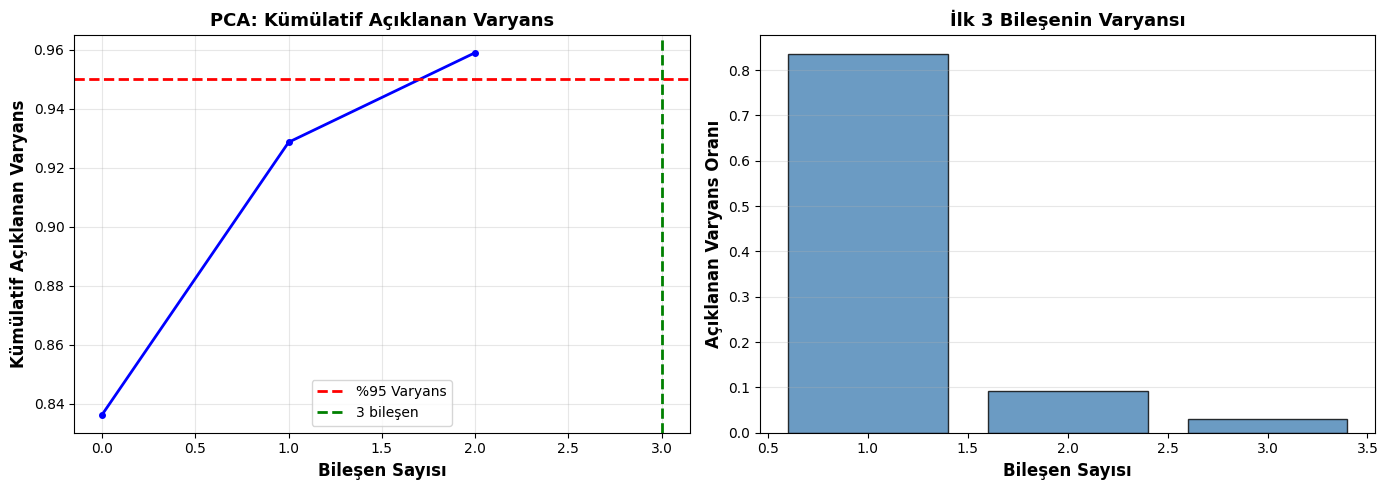

 pca_variance.png kaydedildi


In [9]:
# HÜCRE 8: PCA - Boyut İndirgeme
print("\n" + "="*70)
print("7. PCA - BOYUT İNDİRGEME")
print("="*70)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

print(f" Orijinal özellik sayısı: {X_train_smote.shape[1]}")
print(f" PCA bileşen sayısı: {X_train_pca.shape[1]}")
print(f" Açıklanan varyans: {pca.explained_variance_ratio_.sum():.2%}")
reduction_ratio = (1 - X_train_pca.shape[1]/X_train_smote.shape[1]) * 100
print(f" Boyut indirgeme oranı: {reduction_ratio:.1f}%")

# PCA Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(cumsum_var, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='%95 Varyans')
axes[0].axvline(x=X_train_pca.shape[1], color='g', linestyle='--', linewidth=2,
                label=f'{X_train_pca.shape[1]} bileşen')
axes[0].set_xlabel('Bileşen Sayısı', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Kümülatif Açıklanan Varyans', fontsize=12, fontweight='bold')
axes[0].set_title('PCA: Kümülatif Açıklanan Varyans', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

top_n = min(20, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, top_n+1), pca.explained_variance_ratio_[:top_n],
            color='steelblue', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Bileşen Sayısı', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Açıklanan Varyans Oranı', fontsize=12, fontweight='bold')
axes[1].set_title(f'İlk {top_n} Bileşenin Varyansı', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" pca_variance.png kaydedildi")

In [10]:
# HÜCRE 9: XGBoost Model Eğitimi
print("\n" + "="*70)
print("8. XGBOOST MODELİ EĞİTİMİ")
print("="*70)

model_time = time.time()
model = xgb.XGBClassifier(
    objective='multi:softprob', num_class=4, random_state=RANDOM_STATE,
    n_estimators=150, learning_rate=0.1, max_depth=7,
    eval_metric='mlogloss', n_jobs=-1, tree_method='hist'
)
model.fit(X_train_pca, y_train_smote)
training_time = time.time() - model_time
print(f" Model eğitimi tamamlandı: {training_time:.2f} saniye")

y_pred = model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n XGBoost Sonuçları:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1-Macro: {f1:.4f}")

class_labels = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
print(f"\n Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=class_labels))


8. XGBOOST MODELİ EĞİTİMİ
 Model eğitimi tamamlandı: 24.46 saniye

 XGBoost Sonuçları:
   Accuracy: 0.5199
   F1-Macro: 0.3152

 Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Severity 1       0.05      0.79      0.09      1757
  Severity 2       0.88      0.54      0.67    159235
  Severity 3       0.33      0.44      0.38     33695
  Severity 4       0.08      0.40      0.13      5313

    accuracy                           0.52    200000
   macro avg       0.33      0.54      0.32    200000
weighted avg       0.76      0.52      0.60    200000



In [11]:
# HÜCRE 10: Baseline Modelleri
print("\n" + "="*70)
print("9. BASELINE MODELLERİ")
print("="*70)

# Baseline 1: Uniform Random
print("\n--- Baseline 1: Uniform Random ---")
baseline1 = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
baseline1.fit(X_train_pca, y_train_smote)
y_pred_baseline1 = baseline1.predict(X_test_pca)

baseline1_accuracy = accuracy_score(y_test, y_pred_baseline1)
baseline1_f1_macro = f1_score(y_test, y_pred_baseline1, average='macro')
baseline1_f1_per_class = f1_score(y_test, y_pred_baseline1, average=None)
print(f" Accuracy: {baseline1_accuracy:.4f}")
print(f" F1-Macro: {baseline1_f1_macro:.4f}")
print("Per-class F1:")
for label, score in zip(class_labels, baseline1_f1_per_class):
    print(f"   {label}: {score:.4f}")

# Baseline 2: Logistic Regression
print("\n--- Baseline 2: Logistic Regression ---")
baseline2 = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE,
                               n_jobs=-1, solver='lbfgs')
baseline2.fit(X_train_pca, y_train_smote)
y_pred_baseline2 = baseline2.predict(X_test_pca)

baseline2_accuracy = accuracy_score(y_test, y_pred_baseline2)
baseline2_f1_macro = f1_score(y_test, y_pred_baseline2, average='macro')
baseline2_f1_per_class = f1_score(y_test, y_pred_baseline2, average=None)

print(f" Accuracy: {baseline2_accuracy:.4f}")
print(f" F1-Macro: {baseline2_f1_macro:.4f}")
print("Per-class F1:")
for label, score in zip(class_labels, baseline2_f1_per_class):
    print(f"   {label}: {score:.4f}")


9. BASELINE MODELLERİ

--- Baseline 1: Uniform Random ---
 Accuracy: 0.2505
 F1-Macro: 0.1620
Per-class F1:
   Severity 1: 0.0169
   Severity 2: 0.3814
   Severity 3: 0.2016
   Severity 4: 0.0480

--- Baseline 2: Logistic Regression ---
 Accuracy: 0.2280
 F1-Macro: 0.1349
Per-class F1:
   Severity 1: 0.0212
   Severity 2: 0.3902
   Severity 3: 0.0623
   Severity 4: 0.0660


In [12]:
# HÜCRE 11: Model Karşılaştırması
print("\n" + "="*70)
print("10. MODEL KARŞILAŞTIRMASI")
print("="*70)

xgboost_f1_per_class = f1_score(y_test, y_pred, average=None)

comparison_df = pd.DataFrame({
    'Sev 1': [baseline1_f1_per_class[0], baseline2_f1_per_class[0], xgboost_f1_per_class[0]],
    'Sev 2': [baseline1_f1_per_class[1], baseline2_f1_per_class[1], xgboost_f1_per_class[1]],
    'Sev 3': [baseline1_f1_per_class[2], baseline2_f1_per_class[2], xgboost_f1_per_class[2]],
    'Sev 4': [baseline1_f1_per_class[3], baseline2_f1_per_class[3], xgboost_f1_per_class[3]],
}, index=['Baseline 1 (Uniform)', 'Baseline 2 (LogReg)', 'XGBoost + SMOTE + PCA'])

comparison_df['F1-Macro'] = comparison_df.mean(axis=1)
comparison_df['Accuracy'] = [baseline1_accuracy, baseline2_accuracy, accuracy]

print("\n Karşılaştırma Tablosu:")
print(comparison_df.round(4))


10. MODEL KARŞILAŞTIRMASI

 Karşılaştırma Tablosu:
                        Sev 1   Sev 2   Sev 3   Sev 4  F1-Macro  Accuracy
Baseline 1 (Uniform)   0.0169  0.3814  0.2016  0.0480    0.1620    0.2505
Baseline 2 (LogReg)    0.0212  0.3902  0.0623  0.0660    0.1349    0.2280
XGBoost + SMOTE + PCA  0.0892  0.6678  0.3765  0.1273    0.3152    0.5199



11. VİZÜALİZASYONLAR - Bölüm 1


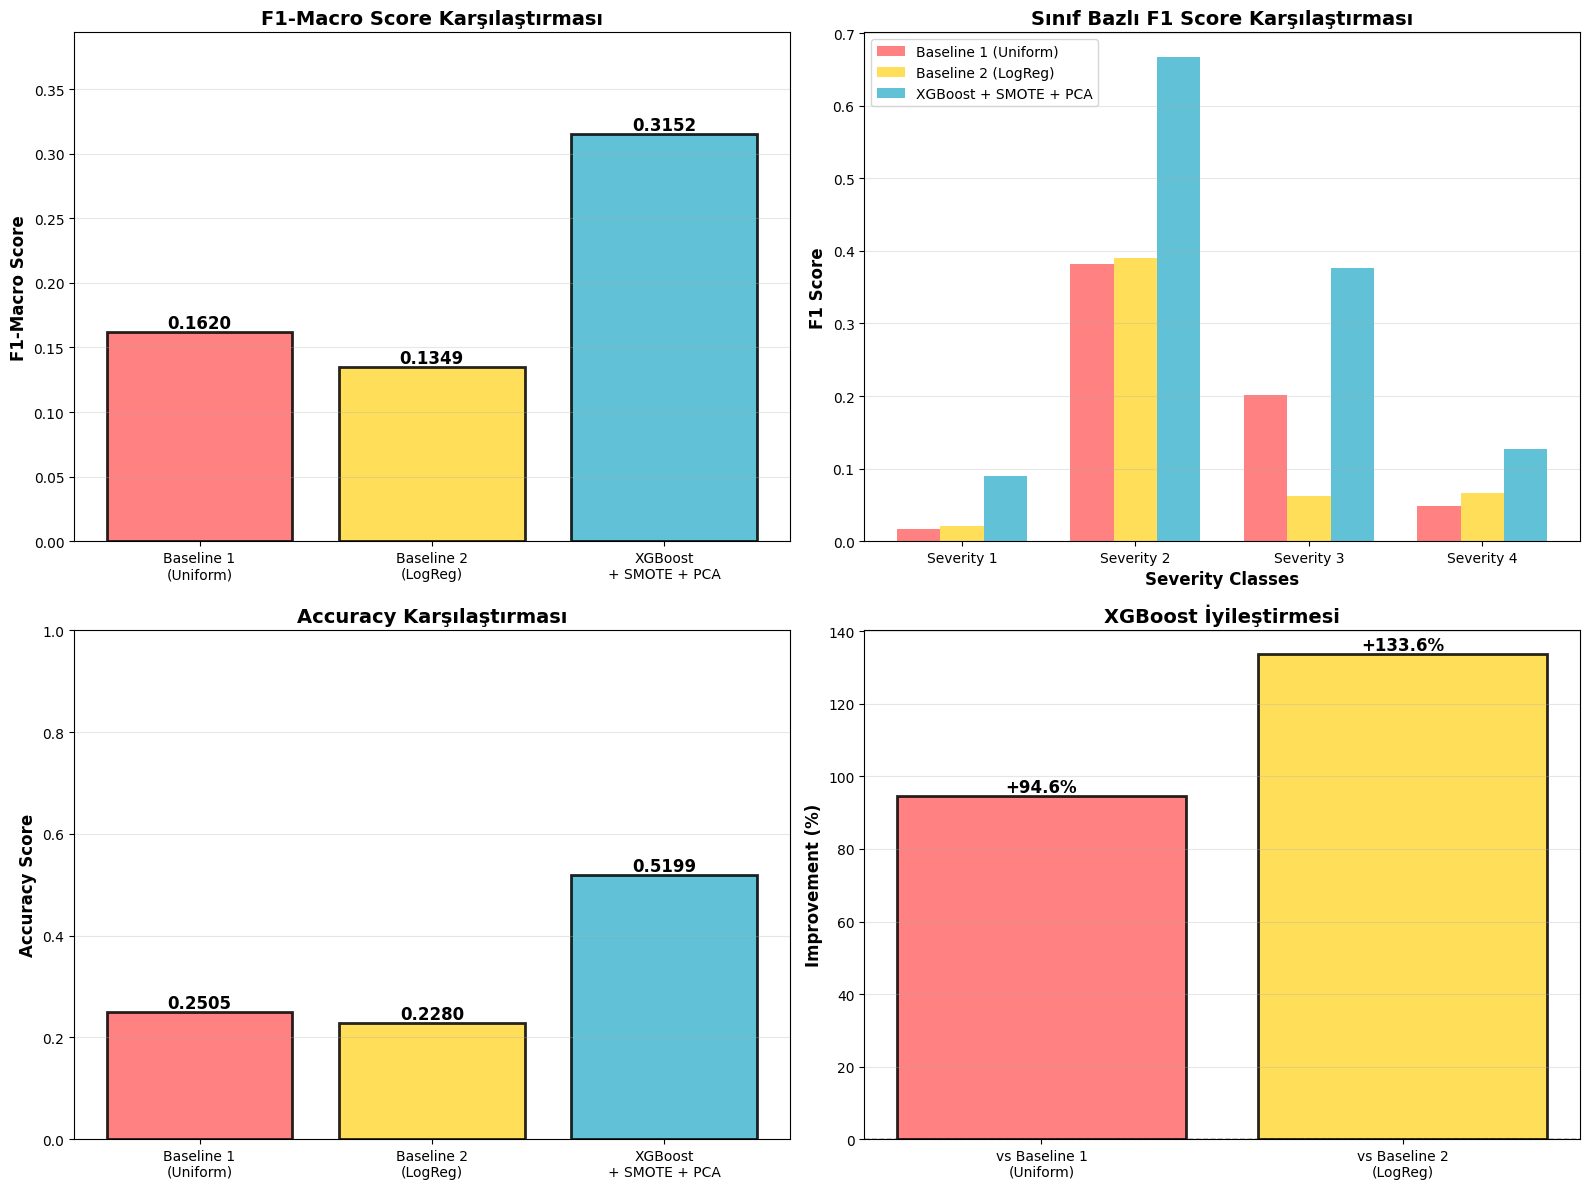

 baseline_comparison_pca.png kaydedildi


In [13]:
# HÜCRE 12: Görselleştirmeler - Bölüm 1
print("\n" + "="*70)
print("11. VİZÜALİZASYONLAR - Bölüm 1")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = ['Baseline 1\n(Uniform)', 'Baseline 2\n(LogReg)', 'XGBoost\n+ SMOTE + PCA']
f1_macros = [baseline1_f1_macro, baseline2_f1_macro, f1]
colors = ['#FF6B6B', '#FFD93D', '#45B7D1']

# F1-Macro
ax1 = axes[0, 0]
bars = ax1.bar(models, f1_macros, color=colors, alpha=0.85, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax1.set_title('F1-Macro Score Karşılaştırması', fontsize=14, fontweight='bold')
ax1.set_ylim([0, max(f1_macros) * 1.25])
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, f1_macros):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{score:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Per-Class F1
ax2 = axes[0, 1]
x = np.arange(len(class_labels))
width = 0.25
ax2.bar(x - width, baseline1_f1_per_class, width, label='Baseline 1 (Uniform)',
        color='#FF6B6B', alpha=0.85)
ax2.bar(x, baseline2_f1_per_class, width, label='Baseline 2 (LogReg)',
        color='#FFD93D', alpha=0.85)
ax2.bar(x + width, xgboost_f1_per_class, width, label='XGBoost + SMOTE + PCA',
        color='#45B7D1', alpha=0.85)
ax2.set_xlabel('Severity Classes', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Sınıf Bazlı F1 Score Karşılaştırması', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(class_labels)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# Accuracy
ax3 = axes[1, 0]
accuracies = [baseline1_accuracy, baseline2_accuracy, accuracy]
bars = ax3.bar(models, accuracies, color=colors, alpha=0.85, edgecolor='black', linewidth=2)
ax3.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax3.set_title('Accuracy Karşılaştırması', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 1.0])
ax3.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{score:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Improvement
ax4 = axes[1, 1]
improvements = [
    ((f1 - baseline1_f1_macro) / baseline1_f1_macro * 100) if baseline1_f1_macro > 0 else 0,
    ((f1 - baseline2_f1_macro) / baseline2_f1_macro * 100) if baseline2_f1_macro > 0 else 0
]
baseline_names = ['vs Baseline 1\n(Uniform)', 'vs Baseline 2\n(LogReg)']
bars = ax4.bar(baseline_names, improvements, color=['#FF6B6B', '#FFD93D'],
               alpha=0.85, edgecolor='black', linewidth=2)
ax4.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax4.set_title('XGBoost İyileştirmesi', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.grid(axis='y', alpha=0.3)
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{imp:+.1f}%',
             ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('baseline_comparison_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print(" baseline_comparison_pca.png kaydedildi")


11. VİZÜALİZASYONLAR - Bölüm 2 (Confusion Matrices)


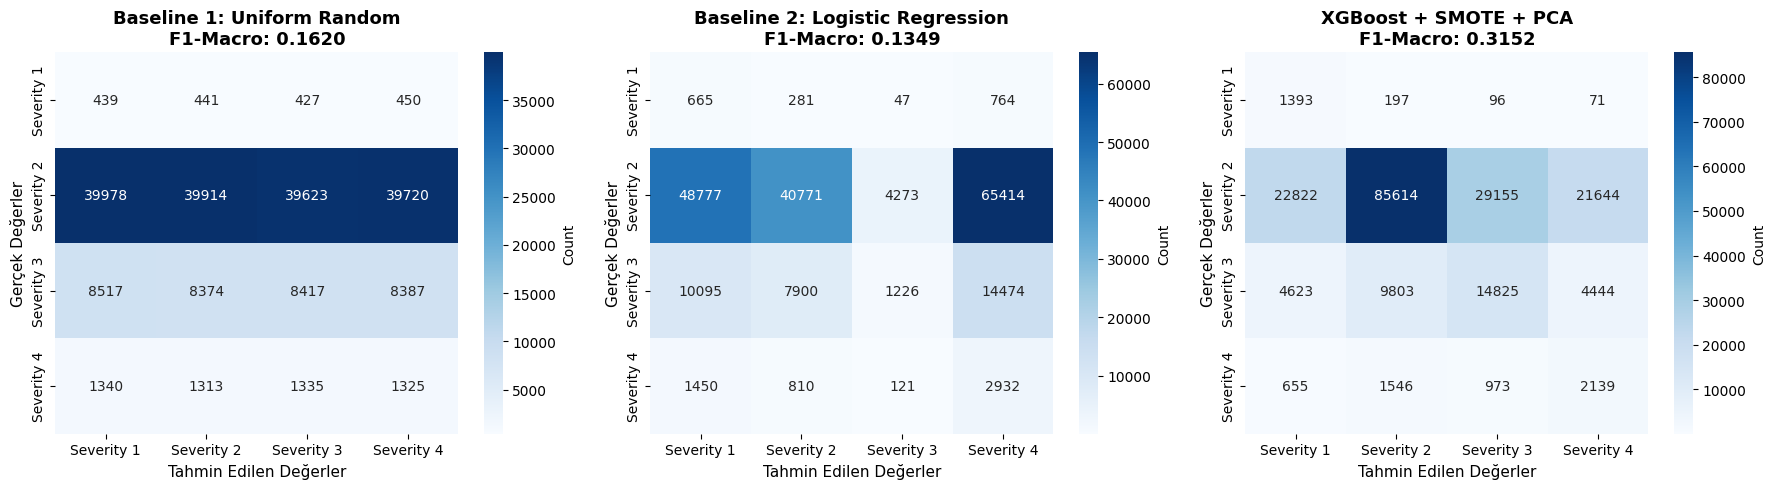

 confusion_matrices_comparison_pca.png kaydedildi


In [14]:
# HÜCRE 13: Görselleştirmeler - Bölüm 2 (Confusion Matrices)
print("\n" + "="*70)
print("11. VİZÜALİZASYONLAR - Bölüm 2 (Confusion Matrices)")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_baseline1 = confusion_matrix(y_test, y_pred_baseline1)
cm_baseline2 = confusion_matrix(y_test, y_pred_baseline2)
cm_xgboost = confusion_matrix(y_test, y_pred)

cm_list = [cm_baseline1, cm_baseline2, cm_xgboost]
titles = ['Baseline 1: Uniform Random', 'Baseline 2: Logistic Regression', 'XGBoost + SMOTE + PCA']
f1_scores = [baseline1_f1_macro, baseline2_f1_macro, f1]

for idx, (cm, title, f1_score) in enumerate(zip(cm_list, titles, f1_scores)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{title}\nF1-Macro: {f1_score:.4f}',
                       fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('Gerçek Değerler', fontsize=11)
    axes[idx].set_xlabel('Tahmin Edilen Değerler', fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrices_comparison_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print(" confusion_matrices_comparison_pca.png kaydedildi")

In [15]:
# HÜCRE 14: Proje Özeti
print("\n" + "="*70)
print("PROJE ÖZETI")
print("="*70)
print("\n Tamamlanan Adımlar:")
print("   1. Veri yükleme ve temizlik")
print("   2. Özellik mühendisliği")
print("   3. Varyans temelli özellik seçimi")
print("   4. StandardScaler ile ölçeklendirme")
print("   5. SMOTE ile sınıf dengeleme")
print("   6. PCA ile boyut indirgeme (%95 varyans)")
print("   7. Baseline 1: Uniform Random (rastgele tahmin)")
print("   8. Baseline 2: Logistic Regression (basit model)")
print("   9. Ana Model: XGBoost + SMOTE + PCA")
print("  10. Model karşılaştırması ve visualizasyon")

print("\n Nihai Sonuçlar:")
print(f"   Baseline 1 (Uniform) F1-Macro: {baseline1_f1_macro:.4f}")
print(f"   Baseline 2 (LogReg) F1-Macro: {baseline2_f1_macro:.4f}")
print(f"   XGBoost F1-Macro: {f1:.4f}")
improvement1 = ((f1 - baseline1_f1_macro) / baseline1_f1_macro * 100) if baseline1_f1_macro > 0 else 0
improvement2 = ((f1 - baseline2_f1_macro) / baseline2_f1_macro * 100) if baseline2_f1_macro > 0 else 0
print(f"   XGBoost İyileştirmesi vs Baseline 1: {improvement1:+.1f}%")
print(f"   XGBoost İyileştirmesi vs Baseline 2: {improvement2:+.1f}%")

print("\n Oluşturulan Dosyalar:")
print("   - pca_variance.png")
print("   - baseline_comparison_pca.png")
print("   - confusion_matrices_comparison_pca.png")

total_time = (time.time() - start_time) / 60
print(f"\n⏱  Toplam Süre: {total_time:.2f} dakika")
print("\n PROJE TAMAMLANDI!")
print("="*70)


PROJE ÖZETI

 Tamamlanan Adımlar:
   1. Veri yükleme ve temizlik
   2. Özellik mühendisliği
   3. Varyans temelli özellik seçimi
   4. StandardScaler ile ölçeklendirme
   5. SMOTE ile sınıf dengeleme
   6. PCA ile boyut indirgeme (%95 varyans)
   7. Baseline 1: Uniform Random (rastgele tahmin)
   8. Baseline 2: Logistic Regression (basit model)
   9. Ana Model: XGBoost + SMOTE + PCA
  10. Model karşılaştırması ve visualizasyon

 Nihai Sonuçlar:
   Baseline 1 (Uniform) F1-Macro: 0.1620
   Baseline 2 (LogReg) F1-Macro: 0.1349
   XGBoost F1-Macro: 0.3152
   XGBoost İyileştirmesi vs Baseline 1: +94.6%
   XGBoost İyileştirmesi vs Baseline 2: +133.6%

 Oluşturulan Dosyalar:
   - pca_variance.png
   - baseline_comparison_pca.png
   - confusion_matrices_comparison_pca.png

⏱  Toplam Süre: 1.86 dakika

 PROJE TAMAMLANDI!
